# Grid Search
- Gre za enega izmed pristopov [hiperoptimizacije](https://en.wikipedia.org/wiki/Hyperparameter_optimization#:~:text=The%20traditional%20way%20of%20performing,space%20of%20a%20learning%20algorithm.)

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Simple Grid Search
- gre za neke vrste brute-force metodo, kjer sprobamo vse možne kombinacije parametrov

In [3]:
# naive grid search implementation
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

print(f"Size of training set: {X_train.shape[0]} size of test set: {X_test.shape[0]}")

best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set
        score = svm.score(X_test, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
print(f"Best score: {best_score:.2f}")
print(f"Best parameters: {best_parameters}")

Size of training set: 112 size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


## The Danger of Overfitting the Parameters and the Validation Set
- ***POMEMBNO*** za optimizacijo moramo uporabiti povsem svež del podatkov (spodaj prikazano kot validation del). V nasprotnem primeru, bi lahko med procesom optimizacije prelili informacije iz podatkov v sam model med optimizacijo in učenjem modela.

- the **training set** to build the model, 
- the **validation (or development) set** to select the parameters of the model
- the **test set** to evaluate the performance of the selected parameters.

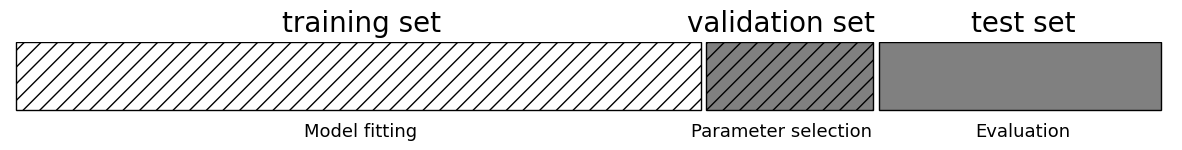

In [4]:
from helpers.plot_cross_validation import plot_threefold_split

plot_threefold_split()

# nova kategorija validation set, ki se uporablja za hiperoptimizacijo
# dvakrat zapored splitamo, da dobimo ločen del podatkov za hiperopzimizacijo

In [5]:
from sklearn.svm import SVC

# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)

# split train+validation set into training and validation sets
# samo za ponazoritev - za te splite obstaja že vgrajena funkcionalost
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)

print(f"Size of training set: {X_train.shape[0]} size of validation set: {X_valid.shape[0]} size of test set: {X_test.shape[0]}\n")

Size of training set: 84 size of validation set: 28 size of test set: 38



In [6]:
best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set
        score = svm.score(X_valid, y_valid)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

In [7]:
# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print(f"Best score on validation set: {best_score:.2f}")
print(f"Best parameters: {best_parameters}")
print(f"Test set score with best parameters: {test_score:.2f}")

# vidimo da ne optimiziramo na TEST setu, saj bi podatke prelili iz train seta in modela na test set
# Test set mora predstavljati podatke, ki jih dobimo na novo in nimajo prej stika z modelom.
# to je sedaj bolj realno - na test setu dobimo 92%.

Best score on validation set: 0.96
Best parameters: {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


## Grid Search with Cross-Validation
- prikazuje kako uporabimo grid-search validacijo z uporabo cross-validation metode razbijanja podatkov

In [9]:
from sklearn.model_selection import cross_val_score

# primer spodaj 6x6 parameterov x 5 cross validation = 180 iteracij grid searcha

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters,
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=10, gamma=0.1)

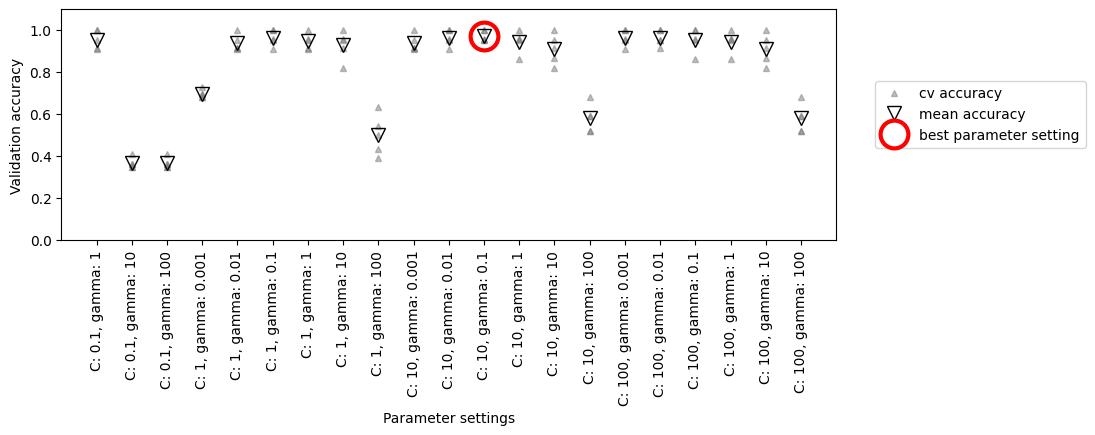

In [10]:
from helpers.plot_grid_search import plot_cross_val_selection

plot_cross_val_selection()
plt.show()

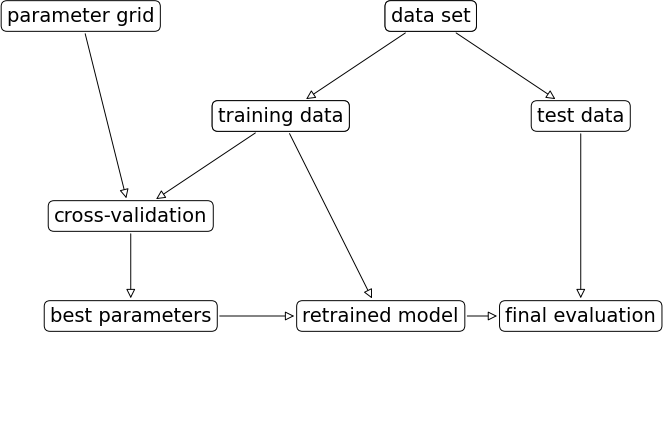

In [9]:
from helpers.plot_grid_search import plot_grid_search_overview

plot_grid_search_overview()

- primer, da ne rabimo GridSearcha delati ročno -> uporabimo vgrajen class GridSearchCV

In [13]:
# 1. ustvarimo list parametrov ki jih uporabimo za grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

print(f"Parameter grid:\n{param_grid}")

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# podamo model, parameter grid in nivo cross-validation-a
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

In [20]:
# opravimo grid-search na train setu z vgrajno cross validacijo
grid_search.fit(X_train, y_train)
# rezultat optimizacije se hrani v spremenljicki grid_search. Vidimo v nadaljevanju, da lahko potem klicemo metodo score dalje kar s to spremenljivko.

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

In [21]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}") 
# grid_search.best_score -> to ni score nad test setom - gre za zgolj teoretično max score nad validation setom

Best parameters: {'C': 10, 'gamma': 0.1}
Best cross-validation score: 0.97


In [18]:
print(f"Test set score: {grid_search.score(X_test, y_test):.2f}")
# ta score je zgolj v tem primeru enak grid_search.best_score, v praksi bo score test seta slabši kot Best cross-validation score

Test set score: 0.97


In [23]:
print(f"Best estimator:\n{grid_search.best_estimator_}")

Best estimator:
SVC(C=10, gamma=0.1)


Opomba: razlika med parametri in hyperparametri - [link](https://towardsdatascience.com/parameters-and-hyperparameters-aa609601a9ac)
- parametri pridejo iz modela in so vezani na značilke
- hiperparametri so output iz hiperoptimizacije (npr. gamma, C)

### Analyzing the result of cross-validation

In [25]:
# convert to DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# show the first 5 rows
results.head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.002396      0.000572         0.001607        0.000586   0.001   
1       0.001204      0.000398         0.001304        0.000402   0.001   
2       0.001406      0.000506         0.000700        0.000601   0.001   
3       0.001904      0.000495         0.001221        0.000391   0.001   
4       0.001802      0.000403         0.001220        0.000271   0.001   

  param_gamma                        params  split0_test_score  \
0       0.001  {'C': 0.001, 'gamma': 0.001}           0.347826   
1        0.01   {'C': 0.001, 'gamma': 0.01}           0.347826   
2         0.1    {'C': 0.001, 'gamma': 0.1}           0.347826   
3           1      {'C': 0.001, 'gamma': 1}           0.347826   
4          10     {'C': 0.001, 'gamma': 10}           0.347826   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.347826           0.363636           0.363636           0.409091   
1           0.347826           0.363636           0.363636           0.409091   
2           0.347826           0.363636           0.363636           0.409091   
3           0.347826           0.363636           0.363636           0.409091   
4           0.347826           0.363636           0.363636           0.409091   

   mean_test_score  std_test_score  rank_test_score  
0         0.366403        0.022485               22  
1         0.366403        0.022485               22  
2         0.366403        0.022485               22  
3         0.366403        0.022485               22  
4         0.366403        0.022485               22

In [27]:
scores = np.array(results["mean_test_score"]).reshape(6, 6)
scores

array([[0.36640316, 0.36640316, 0.36640316, 0.36640316, 0.36640316,
        0.36640316],
       [0.36640316, 0.36640316, 0.36640316, 0.36640316, 0.36640316,
        0.36640316],
       [0.36640316, 0.69644269, 0.90158103, 0.95533597, 0.36640316,
        0.36640316],
       [0.69644269, 0.93794466, 0.96403162, 0.94664032, 0.9284585 ,
        0.50158103],
       [0.93794466, 0.96403162, 0.97312253, 0.94624506, 0.91106719,
        0.58142292],
       [0.96403162, 0.96442688, 0.95494071, 0.94624506, 0.91106719,
        0.58142292]])

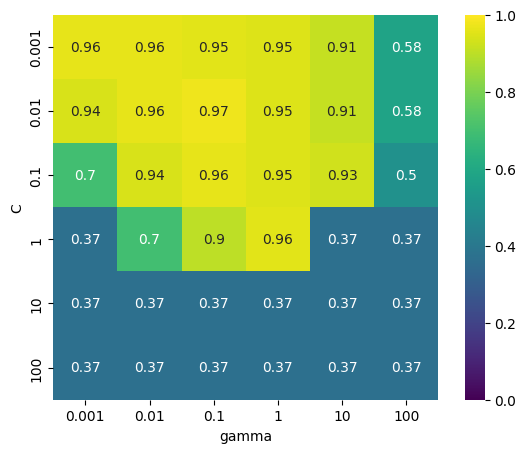

In [28]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(scores[::-1], vmin=0, vmax=1, cmap="viridis", square=True, annot=True)

# axis labels
plt.xlabel('gamma')
plt.ylabel('C')

# xticks
xticks_labels = param_grid['gamma']
plt.xticks(np.arange(len(xticks_labels)) + .5, labels=xticks_labels)

# y ticks
yticks_labels = param_grid['C']
plt.yticks(np.arange(len(yticks_labels)) + .5, labels=yticks_labels)

plt.show()

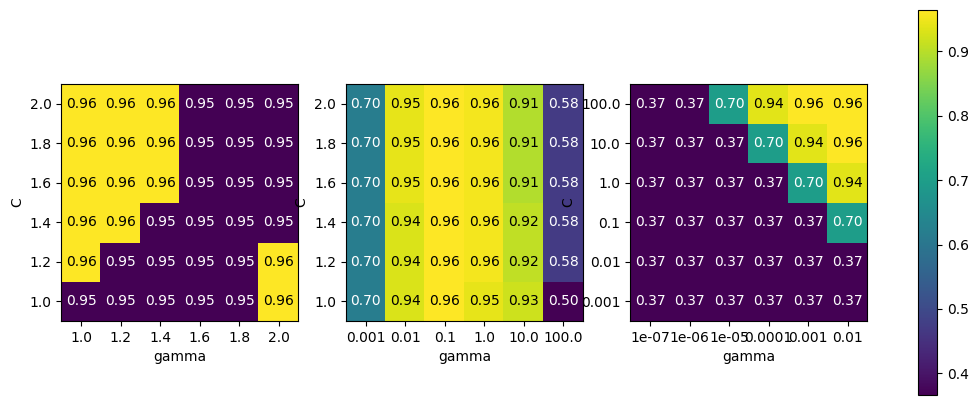

In [29]:
from helpers.tools import heatmap as heatmap_tools

fig, axes = plt.subplots(1, 3, figsize=(13, 5)) 

param_grid_linear = {'C': np.linspace(1, 2, 6), 'gamma': np.linspace(1, 2, 6)}
param_grid_one_log = {'C': np.linspace(1, 2, 6), 'gamma': np.logspace(-3, 2, 6)}
param_grid_range = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-7, -2, 6)}


for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)
    # plot the mean cross-validation scores
    scores_image = heatmap_tools(scores, xlabel='gamma', 
                                               ylabel='C', xticklabels=param_grid['gamma'], 
                                               yticklabels=param_grid['C'], cmap="viridis", ax=ax)

plt.colorbar(scores_image, ax=axes.tolist())
plt.show()

# Primer kaj nam povejo slike
# 1- vzeli smo premajhno območje parametrov, ni velikih razlik v score-u na izbranem področju
# 2- C parameter nima vpliva, mora imeti večjo skalo
# 3- zanimiv del je na robu (zgoraj desno), moramo razširiti območje parametrov bolj v tem delu

### Search over spaces that are not grids
- Kako uporabiti grid-search, ko imamo npr. kategorične parametre

In [30]:
# grid podamo kot dictionary
param_grid = [{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
            {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

In [29]:
param_grid

[{'kernel': ['rbf'],
  'C': [0.001, 0.01, 0.1, 1, 10, 100],
  'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
 {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

In [31]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.97


Let’s look at the `cv_results_` again. As expected, if kernel is 'linear', then only C is
varied:

In [32]:
results = pd.DataFrame(grid_search.cv_results_)
results.T

0   \
mean_fit_time                                           0.001802   
std_fit_time                                            0.000479   
mean_score_time                                         0.000415   
std_score_time                                          0.000508   
param_C                                                    0.001   
param_gamma                                                0.001   
param_kernel                                                 rbf   
params             {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}   
split0_test_score                                       0.347826   
split1_test_score                                       0.347826   
split2_test_score                                       0.363636   
split3_test_score                                       0.363636   
split4_test_score                                       0.409091   
mean_test_score                                         0.366403   
std_test_score                                          0.022485   
rank_test_score                                               27   

                                                             1   \
mean_fit_time                                          0.001108   
std_fit_time                                           0.000808   
mean_score_time                                        0.000807   
std_score_time                                         0.000759   
param_C                                                   0.001   
param_gamma                                                0.01   
param_kernel                                                rbf   
params             {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}   
split0_test_score                                      0.347826   
split1_test_score                                      0.347826   
split2_test_score                                      0.363636   
split3_test_score                                      0.363636   
split4_test_score                                      0.409091   
mean_test_score                                        0.366403   
std_test_score                                         0.022485   
rank_test_score                                              27   

                                                            2   \
mean_fit_time                                          0.00115   
std_fit_time                                          0.000185   
mean_score_time                                       0.001322   
std_score_time                                        0.000856   
param_C                                                  0.001   
param_gamma                                                0.1   
param_kernel                                               rbf   
params             {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}   
split0_test_score                                     0.347826   
split1_test_score                                     0.347826   
split2_test_score                                     0.363636   
split3_test_score                                     0.363636   
split4_test_score                                     0.409091   
mean_test_score                                       0.366403   
std_test_score                                        0.022485   
rank_test_score                                             27   

                                                          3   \
mean_fit_time                                       0.001819   
std_fit_time                                        0.000506   
mean_score_time                                       0.0008   
std_score_time                                        0.0004   
param_C                                                0.001   
param_gamma                                                1   
param_kernel                                             rbf   
params             {'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}   
split0_test_score                                   0.347826   
sp

### Using different cross-validation strategies with grid search and Parallelizing

### Nested cross-validation
- zgolj pove, ali se je model dobro generaliziral, ne dobimo pa na podlagi tega postopka boljšega modela
- v bistvu gre za to da celotno izbiro train-validation-test seta še dodatno razdelimo na več iteracij
### Paralelizacija
- parameter n_jobs

In [34]:
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1), iris.data, iris.target, cv=5) # n_jobs -> parameter za paralelizacijo

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.96666667 1.         0.9        0.96666667 1.        ]
Mean cross-validation score:  0.9666666666666668


Opomba: pri paralelizaciji se paralelizira tudi hramba podatkov - torej RAM requirements